In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-plate-detection/annotations/Cars339.xml
/kaggle/input/car-plate-detection/annotations/Cars13.xml
/kaggle/input/car-plate-detection/annotations/Cars74.xml
/kaggle/input/car-plate-detection/annotations/Cars16.xml
/kaggle/input/car-plate-detection/annotations/Cars291.xml
/kaggle/input/car-plate-detection/annotations/Cars236.xml
/kaggle/input/car-plate-detection/annotations/Cars429.xml
/kaggle/input/car-plate-detection/annotations/Cars132.xml
/kaggle/input/car-plate-detection/annotations/Cars251.xml
/kaggle/input/car-plate-detection/annotations/Cars51.xml
/kaggle/input/car-plate-detection/annotations/Cars165.xml
/kaggle/input/car-plate-detection/annotations/Cars313.xml
/kaggle/input/car-plate-detection/annotations/Cars240.xml
/kaggle/input/car-plate-detection/annotations/Cars201.xml
/kaggle/input/car-plate-detection/annotations/Cars412.xml
/kaggle/input/car-plate-detection/annotations/Cars227.xml
/kaggle/input/car-plate-detection/annotations/Cars145.xml
/kaggle/input/car-

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import cv2
import shutil
from glob import glob
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

In [3]:
print(f'Cuda Avalailable: {torch.cuda.is_available()}')
print(f'GPU Count: {torch.cuda.device_count()}')

Cuda Avalailable: True
GPU Count: 2


In [4]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 14.3 MB/s eta 0:00:00a 0:00:01


In [5]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 2.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.3 MB/s eta 0:00:0000:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [6]:
dataset_path='/kaggle/input/car-plate-detection'

In [9]:
import re

def find_number_in_string(filename):
    match=re.search(r'(\d+)',filename)
    if match:
        return int(match.group(0))
    return 0

In [10]:
find_number_in_string('file122.txt')

122

In [39]:
labels_dict=dict(
                img_path=[],
                xmin=[],
                xmax=[],
                ymin=[],
                ymax=[],
                img_w=[],
                img_h=[]
)

In [40]:
labels_dict

{'img_path': [],
 'xmin': [],
 'xmax': [],
 'ymin': [],
 'ymax': [],
 'img_w': [],
 'img_h': []}

In [41]:
xml_files=glob(f'{dataset_path}/annotations/*.xml')
xml_files

['/kaggle/input/car-plate-detection/annotations/Cars339.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars13.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars74.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars16.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars291.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars236.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars429.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars132.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars251.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars51.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars165.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars313.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars240.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars201.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars412.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars227.xml',
 '/kaggle/in

In [42]:
for filename in sorted(xml_files,key=find_number_in_string):
    
    info=xet.parse(filename)
    root=info.getroot()
    member_object=root.find('object')
    labels_info=member_object.find('bndbox')

    xmin=int(labels_info.find('xmin').text)
    xmax=int(labels_info.find('xmax').text)
    ymin=int(labels_info.find('ymin').text)
    ymax=int(labels_info.find('ymax').text)
    
    image_name=root.find('filename').text
    image_path=os.path.join('/kaggle/input/car-plate-detection/images',image_name)
#     height=int(root.find('size').find('height').text)
#     width=int(root.find('size').find('width').text)
    height,width,_=cv2.imread(image_path).shape

    labels_dict['img_path'].append(image_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

In [43]:
all_data=pd.DataFrame(labels_dict)
all_data

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/kaggle/input/car-plate-detection/images/Cars0...,226,419,125,173,500,268
1,/kaggle/input/car-plate-detection/images/Cars1...,134,262,128,160,400,248
2,/kaggle/input/car-plate-detection/images/Cars2...,229,270,176,193,400,400
3,/kaggle/input/car-plate-detection/images/Cars3...,142,261,128,157,400,225
4,/kaggle/input/car-plate-detection/images/Cars4...,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/kaggle/input/car-plate-detection/images/Cars4...,142,258,128,157,400,225
429,/kaggle/input/car-plate-detection/images/Cars4...,86,208,166,195,301,400
430,/kaggle/input/car-plate-detection/images/Cars4...,38,116,159,197,400,225
431,/kaggle/input/car-plate-detection/images/Cars4...,55,343,82,147,400,192


In [45]:
train,test=train_test_split(all_data,test_size=0.1,random_state=42)
train,val=train_test_split(train,train_size=8/9,random_state=42)

print(f'''
    len(train): {len(train)}
    len(val): {len(val)}
    len(test): {len(test)}
''')


    len(train): 345
    len(val): 44
    len(test): 44



In [97]:
def make_split_folder_in_yolo_format(split_name,split_df):
    
    labels_path=os.path.join('datasets','cars_license_plate_new',split_name,'labels')
    images_path=os.path.join('datasets','cars_license_plate_new',split_name,'images')
    
    os.makedirs(labels_path)
    os.makedirs(images_path)
    
    for _,row in split_df.iterrows():
        
        img_name,img_extension=os.path.splitext(os.path.basename(row['img_path']))
        
        x_center=(row['xmin']+row['xmax'])/2/row['img_w']
        y_center=(row['ymin']+row['ymax'])/2/row['img_h']
        width=(row['xmax']-row['xmin'])/row['img_w']
        height=(row['ymax']-row['ymin'])/row['img_h']
        
        label_path=os.path.join(labels_path,f'{img_name}.txt')
        
        with open(label_path,'w') as f:
            f.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
            
        shutil.copy(row['img_path'],os.path.join(images_path,img_name+img_extension))
        
    print(f"created '{images_path}' and '{labels_path}'")

In [98]:
make_split_folder_in_yolo_format(split_name='train',split_df=train)
make_split_folder_in_yolo_format(split_name='val',split_df=val)
make_split_folder_in_yolo_format(split_name='test',split_df=test)

created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels'
created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


In [104]:
datasets_yaml='''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

nc: 1
names: ['license_plate']
'''

with open('datasets.yaml','w') as f:
    f.write(datasets_yaml)

In [105]:
from ultralytics import YOLO

model=YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 74.3MB/s]


In [106]:
model.train(data='datasets.yaml',
           epochs=100,
           batch=16,
           device='cuda',
           imgsz=320,
           cache=True)

Ultralytics YOLOv8.2.49 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

train: Scanning /kaggle/working/datasets/cars_license_plate_new/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 464.47it/s]

train: New cache created: /kaggle/working/datasets/cars_license_plate_new/train/labels.cache



train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:01<00:00, 190.01it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/cars_license_plate_new/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 442.68it/s]

val: New cache created: /kaggle/working/datasets/cars_license_plate_new/val/labels.cache



val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 189.18it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.929G      1.778      3.023      1.372         18        320: 100%|██████████| 22/22 [00:04<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         44         44    0.00427      0.932      0.435      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.881G      1.513      1.491      1.122         21        320: 100%|██████████| 22/22 [00:01<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


                   all         44         44          1       0.22      0.312      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.883G      1.478      1.335      1.126         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]

                   all         44         44      0.905      0.218      0.473      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.883G       1.45      1.273      1.148         18        320: 100%|██████████| 22/22 [00:01<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.02it/s]


                   all         44         44      0.758      0.545      0.709      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.883G      1.471      1.198      1.166         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.61it/s]

                   all         44         44       0.46      0.523      0.467      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.868G      1.453      1.181      1.159         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]


                   all         44         44       0.42      0.386      0.409      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.883G      1.473      1.153      1.172          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.66it/s]

                   all         44         44      0.755      0.477      0.573      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.868G       1.47      1.082      1.167         13        320: 100%|██████████| 22/22 [00:01<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


                   all         44         44      0.772      0.773       0.76      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.883G      1.433      1.067      1.171         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.08it/s]

                   all         44         44      0.861      0.704      0.787      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.868G      1.424      1.049      1.147         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]

                   all         44         44      0.761      0.841      0.865      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.883G      1.423      1.038      1.132         21        320: 100%|██████████| 22/22 [00:01<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


                   all         44         44      0.888      0.901      0.889      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.868G      1.357     0.9446      1.136         16        320: 100%|██████████| 22/22 [00:01<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.82it/s]

                   all         44         44      0.836      0.886       0.87       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.883G      1.358     0.9184      1.142         20        320: 100%|██████████| 22/22 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]

                   all         44         44      0.812      0.881      0.873      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.868G      1.339     0.9229      1.116         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


                   all         44         44      0.925       0.84      0.877      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.883G      1.319      0.894      1.114         19        320: 100%|██████████| 22/22 [00:01<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


                   all         44         44       0.92      0.784      0.894      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.868G      1.333     0.9125      1.094         20        320: 100%|██████████| 22/22 [00:01<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.39it/s]

                   all         44         44      0.825      0.795      0.866      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.883G      1.262     0.8618      1.059         22        320: 100%|██████████| 22/22 [00:01<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.35it/s]


                   all         44         44       0.88      0.864      0.893      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.868G      1.262     0.8421      1.103         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.24it/s]


                   all         44         44       0.89       0.92      0.929      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.883G      1.253     0.8087      1.078         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.24it/s]

                   all         44         44      0.899      0.818      0.886      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.868G      1.231     0.8131      1.089         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.03it/s]


                   all         44         44       0.95      0.869      0.921      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.883G      1.196     0.8006      1.059         21        320: 100%|██████████| 22/22 [00:01<00:00, 11.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.41it/s]


                   all         44         44      0.837      0.934      0.946      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.868G      1.216      0.757      1.059         18        320: 100%|██████████| 22/22 [00:01<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.63it/s]

                   all         44         44      0.921      0.886      0.914      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.883G      1.188     0.7391      1.058         20        320: 100%|██████████| 22/22 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.88it/s]

                   all         44         44      0.908      0.864      0.893      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.868G       1.13     0.7157      1.022         17        320: 100%|██████████| 22/22 [00:01<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.84it/s]

                   all         44         44      0.888      0.773      0.872       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.883G      1.112     0.7219      1.015         25        320: 100%|██████████| 22/22 [00:01<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.64it/s]

                   all         44         44      0.844      0.859       0.87      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.868G      1.234     0.7623      1.052         19        320: 100%|██████████| 22/22 [00:01<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.35it/s]


                   all         44         44      0.928      0.884       0.92      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.883G      1.171     0.7321      1.015         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.27it/s]


                   all         44         44      0.904      0.909      0.912      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.868G      1.116      0.718       1.02         16        320: 100%|██████████| 22/22 [00:01<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


                   all         44         44      0.892      0.795      0.873      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.883G      1.186     0.7308      1.038         22        320: 100%|██████████| 22/22 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.90it/s]

                   all         44         44       0.99      0.841      0.942      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.868G      1.188     0.7373      1.049         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.44it/s]

                   all         44         44      0.939      0.841      0.893      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.881G       1.16     0.7172      1.028         11        320: 100%|██████████| 22/22 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.73it/s]

                   all         44         44      0.926      0.858      0.925      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.868G      1.141     0.6972      1.031         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.78it/s]

                   all         44         44      0.926      0.857      0.937      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.883G      1.067     0.6844       1.02         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


                   all         44         44       0.89      0.818      0.889      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.868G      1.098     0.6604      1.039         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.88it/s]


                   all         44         44      0.891      0.841      0.881      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.883G      1.051     0.6339      1.006         13        320: 100%|██████████| 22/22 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.39it/s]


                   all         44         44      0.892      0.841      0.888      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.868G      1.092     0.6561       1.01         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.54it/s]

                   all         44         44      0.894      0.818      0.866      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.883G      1.124      0.684      1.021         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.82it/s]


                   all         44         44      0.896      0.841      0.881      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.868G      1.054     0.6521     0.9849         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.63it/s]

                   all         44         44      0.922      0.909      0.935       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.883G      1.102      0.658      1.042         12        320: 100%|██████████| 22/22 [00:01<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.61it/s]

                   all         44         44      0.905      0.861      0.929      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.868G      1.049     0.6774     0.9887         17        320: 100%|██████████| 22/22 [00:01<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.21it/s]


                   all         44         44      0.928      0.886      0.897       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.883G      1.074     0.6687     0.9941         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.83it/s]

                   all         44         44      0.902      0.932      0.953      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.868G      1.024     0.6297     0.9612         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.19it/s]


                   all         44         44      0.927      0.869      0.935       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.883G      1.026     0.6192     0.9889         13        320: 100%|██████████| 22/22 [00:01<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.06it/s]


                   all         44         44      0.875      0.886      0.938      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.868G      1.021     0.6264     0.9987         12        320: 100%|██████████| 22/22 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.09it/s]


                   all         44         44      0.972      0.779       0.92       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.883G     0.9805     0.5909     0.9801         20        320: 100%|██████████| 22/22 [00:01<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.35it/s]


                   all         44         44      0.937      0.841      0.906      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.868G      1.033     0.6145     0.9782         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.17it/s]


                   all         44         44      0.898      0.864      0.904      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.883G     0.9541      0.591     0.9589         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]

                   all         44         44      0.803      0.864      0.871      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.868G       1.04     0.6261     0.9888         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.62it/s]

                   all         44         44      0.908        0.9      0.911      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.883G     0.9915     0.6055     0.9884         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.58it/s]


                   all         44         44      0.905      0.909      0.903      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.868G     0.9721     0.5908     0.9732         24        320: 100%|██████████| 22/22 [00:01<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]

                   all         44         44      0.898      0.886      0.898      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.883G     0.9495     0.5978     0.9576         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]

                   all         44         44      0.881      0.886      0.864      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.868G     0.9475     0.5646     0.9659         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.31it/s]


                   all         44         44      0.842      0.864      0.885      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.883G     0.9762     0.5693     0.9586         12        320: 100%|██████████| 22/22 [00:01<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.52it/s]


                   all         44         44      0.876      0.864       0.88      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.868G      0.967     0.5931     0.9548         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.02it/s]


                   all         44         44       0.88      0.886       0.88      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.883G     0.9627     0.5703     0.9719         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.88it/s]

                   all         44         44      0.899      0.886       0.87      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.868G     0.9353     0.5622     0.9562         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.80it/s]

                   all         44         44      0.909      0.932      0.914      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.883G     0.9037     0.5709     0.9596         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.76it/s]

                   all         44         44      0.929      0.893      0.929      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.868G     0.8631      0.553     0.9513         17        320: 100%|██████████| 22/22 [00:01<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.49it/s]

                   all         44         44      0.937      0.841      0.926       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.883G     0.9055     0.5378     0.9419         13        320: 100%|██████████| 22/22 [00:01<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.74it/s]

                   all         44         44      0.797      0.909      0.912      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.868G      0.874     0.5287     0.9471         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.30it/s]


                   all         44         44       0.81      0.886      0.893      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.883G     0.8757     0.5369       0.94         19        320: 100%|██████████| 22/22 [00:01<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.51it/s]


                   all         44         44       0.82      0.929      0.886      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.868G     0.8794      0.547     0.9325         12        320: 100%|██████████| 22/22 [00:01<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.77it/s]

                   all         44         44       0.83      0.909      0.854       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.883G     0.9084     0.5433     0.9479         19        320: 100%|██████████| 22/22 [00:01<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.70it/s]

                   all         44         44      0.848      0.884      0.885      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.868G     0.8797     0.5524     0.9433         14        320: 100%|██████████| 22/22 [00:01<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.60it/s]

                   all         44         44      0.885      0.795      0.879      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.883G     0.9093     0.5482     0.9574         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.89it/s]

                   all         44         44      0.828      0.886      0.865       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.868G     0.8709     0.5176     0.9503         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.13it/s]


                   all         44         44      0.903      0.844      0.861      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.883G     0.8699     0.5223      0.948         16        320: 100%|██████████| 22/22 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.58it/s]


                   all         44         44      0.832      0.818      0.855      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.868G     0.8794     0.5144     0.9425         14        320: 100%|██████████| 22/22 [00:01<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.86it/s]

                   all         44         44      0.856      0.841      0.877      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.883G     0.8483     0.5047     0.9334         18        320: 100%|██████████| 22/22 [00:01<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.08it/s]

                   all         44         44      0.926      0.854      0.894      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.868G     0.8764     0.5183     0.9466         19        320: 100%|██████████| 22/22 [00:01<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.00it/s]

                   all         44         44      0.892      0.886      0.902      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.883G     0.8338     0.4992     0.9093         14        320: 100%|██████████| 22/22 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.72it/s]

                   all         44         44      0.866      0.909      0.903      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.868G     0.8582      0.515     0.9402         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.71it/s]

                   all         44         44      0.883       0.86        0.9      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.883G     0.8464     0.5221     0.9394         19        320: 100%|██████████| 22/22 [00:01<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.31it/s]


                   all         44         44      0.879      0.864      0.898      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.868G     0.8724     0.5112     0.9225         14        320: 100%|██████████| 22/22 [00:01<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.48it/s]

                   all         44         44      0.889      0.906      0.924      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.883G      0.827     0.5015     0.9279         14        320: 100%|██████████| 22/22 [00:01<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.76it/s]

                   all         44         44      0.847      0.909      0.912      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.868G     0.7885     0.4919     0.9127         20        320: 100%|██████████| 22/22 [00:01<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.82it/s]

                   all         44         44      0.884      0.909      0.931       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.883G     0.7946     0.4885     0.9105         13        320: 100%|██████████| 22/22 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.02it/s]

                   all         44         44      0.893      0.886      0.921      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.868G      0.811      0.483     0.9272         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.81it/s]

                   all         44         44       0.97      0.864      0.927      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.883G     0.8175     0.4708     0.9195         16        320: 100%|██████████| 22/22 [00:01<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.18it/s]

                   all         44         44      0.966      0.864      0.932      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.868G     0.8077     0.4754     0.9173         22        320: 100%|██████████| 22/22 [00:01<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.49it/s]

                   all         44         44       0.92      0.864      0.904      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.883G     0.7993     0.4742     0.9269         22        320: 100%|██████████| 22/22 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.90it/s]

                   all         44         44      0.923      0.864      0.899      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.868G     0.8051     0.4845     0.9267         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.85it/s]

                   all         44         44      0.882      0.864      0.901      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.883G     0.7916     0.4713     0.9085         21        320: 100%|██████████| 22/22 [00:01<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


                   all         44         44      0.844      0.859      0.885      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.868G     0.7456     0.4516     0.8914         27        320: 100%|██████████| 22/22 [00:01<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.70it/s]

                   all         44         44      0.827      0.871      0.903      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.883G     0.7484     0.4505     0.9084         21        320: 100%|██████████| 22/22 [00:02<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.45it/s]


                   all         44         44      0.843      0.854      0.906      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.868G      0.757     0.4538     0.9127         25        320: 100%|██████████| 22/22 [00:01<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.19it/s]

                   all         44         44      0.862      0.886      0.911      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.883G     0.7687     0.4559     0.9095         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.50it/s]


                   all         44         44      0.867      0.909      0.942      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.868G     0.7631     0.4494      0.909         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.13it/s]

                   all         44         44      0.863      0.909      0.924       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.883G     0.7745     0.4635     0.9068         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.46it/s]


                   all         44         44        0.9      0.822      0.894      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.868G     0.7337     0.4385     0.9162         13        320: 100%|██████████| 22/22 [00:01<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.45it/s]

                   all         44         44      0.862      0.886      0.897      0.552


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.881G     0.9503      0.523      1.005          9        320: 100%|██████████| 22/22 [00:02<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]

                   all         44         44      0.845       0.87      0.889      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.868G     0.9776     0.5236     0.9918          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.80it/s]

                   all         44         44      0.855      0.864      0.886      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.883G     0.9787     0.5126      1.002          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.48it/s]


                   all         44         44      0.879      0.886      0.916       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.868G     0.9758     0.5003      1.009          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.60it/s]

                   all         44         44      0.857      0.864      0.874      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.883G     0.9373     0.4865     0.9919          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.92it/s]

                   all         44         44      0.857      0.864      0.877      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.868G     0.9064     0.4717     0.9698          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.72it/s]

                   all         44         44      0.859      0.886      0.906       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.881G     0.9417     0.4908     0.9863          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.58it/s]

                   all         44         44      0.858      0.886      0.895      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.866G     0.9241     0.4848     0.9624          8        320: 100%|██████████| 22/22 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.62it/s]

                   all         44         44      0.862      0.886      0.914       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.883G     0.9015     0.4736     0.9943          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.68it/s]

                   all         44         44      0.864      0.866      0.914       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.868G     0.9462     0.4832     0.9779          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.35it/s]

                   all         44         44      0.893      0.864      0.895      0.549



100 epochs completed in 0.096 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.49 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]


                   all         44         44      0.903      0.932      0.953      0.586
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▂▁▆▇▇▇██▇█▇█▇▇███▇▇▇▇▇▇▇▇▇▇▇███▇▇█▇▇▇▇█
metrics/mAP50-95(B),▂▃▁▄▅▆▆▆▆▇▆▆▇▇▆▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█
metrics/precision(B),▁█▄▇▇▇▇▇▇██▇█▇▇█▇█▇█▇▇█▇▇▇▇█▇▇▇█▇▇▇▇▇▇▇█
metrics/recall(B),█▁▃▆█▇▇██▇█▇▇▇▇▇█▆▇██████▇▇▇▇██▇▇▇█▇▇▇██
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▃▃▂▂


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7af08822cd60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [125]:
class_id, x_center, y_center, width, height = map(float,a[0].strip().split())

In [129]:
log_dir=max(glob('runs/detect/train*'),key=find_number_in_string)

results=pd.read_csv(os.path.join(log_dir,'results.csv'))

In [130]:
results

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.77810,3.02260,1.37180,0.00427,0.93182,0.43514,0.19316,1.5126,3.10880,1.1348,0.000420,0.000420,0.000420
1,2,1.51340,1.49070,1.12220,1.00000,0.21992,0.31153,0.16783,1.7176,3.07180,1.2596,0.000851,0.000851,0.000851
2,3,1.47780,1.33510,1.12570,0.90523,0.21762,0.47337,0.25423,1.8057,2.66780,1.3021,0.001274,0.001274,0.001274
3,4,1.44990,1.27340,1.14790,0.75761,0.54545,0.70857,0.35057,1.8636,2.10720,1.3638,0.001688,0.001688,0.001688
4,5,1.47140,1.19840,1.16580,0.45968,0.52273,0.46695,0.24208,1.8978,2.16040,1.5501,0.001921,0.001921,0.001921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0.90638,0.47172,0.96981,0.85931,0.88636,0.90641,0.54974,1.4639,0.66558,1.2651,0.000119,0.000119,0.000119
96,97,0.94166,0.49079,0.98627,0.85843,0.88636,0.89547,0.55509,1.4418,0.66195,1.2591,0.000099,0.000099,0.000099
97,98,0.92409,0.48478,0.96244,0.86244,0.88636,0.91370,0.56028,1.4265,0.65986,1.2504,0.000079,0.000079,0.000079
98,99,0.90151,0.47364,0.99432,0.86394,0.86588,0.91355,0.54964,1.4502,0.66213,1.2636,0.000060,0.000060,0.000060


In [135]:
results.columns=results.columns.str.strip()
epochs=results.index+1
epochs

RangeIndex(start=1, stop=101, step=1)

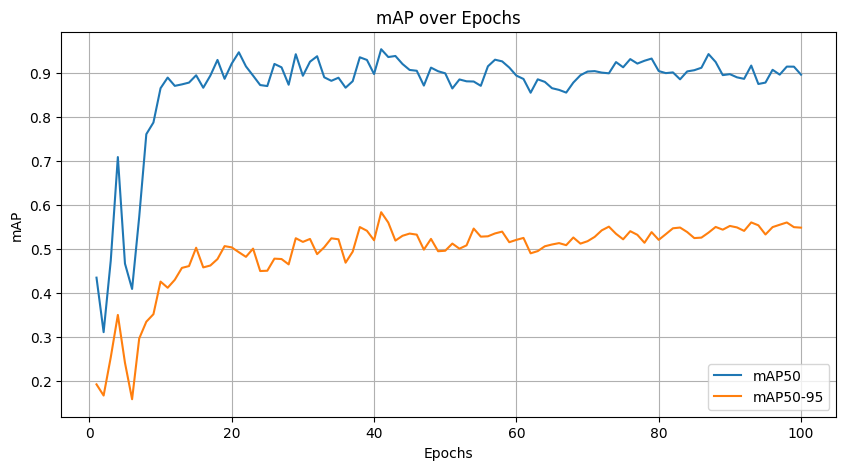

In [139]:
map_0_5=results['metrics/mAP50(B)']
map_50_95=results['metrics/mAP50-95(B)']

plt.figure(figsize=(10,5))
plt.plot(epochs,map_0_5,label='mAP50')
plt.plot(epochs,map_50_95,label='mAP50-95')

plt.xlabel('Epochs')
plt.ylabel('mAP')

plt.title('mAP over Epochs')

plt.grid()

plt.legend()
plt.show()

In [136]:
results.columns

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

In [141]:
model.save('license_plate_yolov8n.pt')

In [170]:
def detect(image_path):
    
    image=cv2.imread(image_path)
    result=model.predict(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    for res in result:
        for box in res.boxes:
            x1,y1,x2,y2=map(int,box.xyxy[0])
            confidence=box.conf[0]

            cv2.rectangle(image,(x1,y1),(x2,y2),(0,255,0),2)
            cv2.putText(image,f'{confidence*100:.2f}%',(x1,y1-10),cv2.FONT_HERSHEY_SIMPLEX,0.9,(255,0,0),2)

    plt.imshow(image)
    plt.axis('off')
    plt.show()


image 1/1 /kaggle/working/datasets/cars_license_plate_new/test/images/Cars400.png: 224x320 1 license_plate, 7.7ms
Speed: 1.1ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 320)


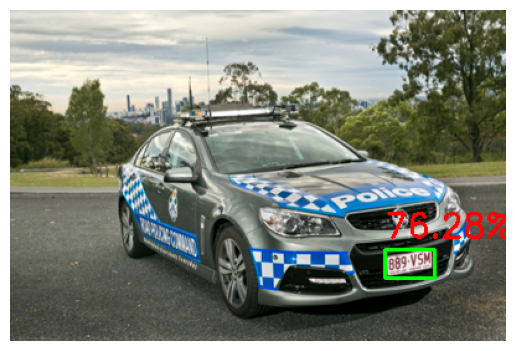

In [185]:
detect('/kaggle/working/datasets/cars_license_plate_new/test/images/Cars400.png')

In [186]:
!pip install pytesseract

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [188]:
import pytesseract
from pytesseract import Output

In [205]:
def detect(image_path,model):
    
    image=cv2.imread(image_path)
    result=model.predict(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    for res in result:
        for box in res.boxes:
            x1,y1,x2,y2=map(int,box.xyxy[0])
            confidence=box.conf[0]

            cv2.rectangle(image,(x1,y1),(x2,y2),(0,255,0),2)
            cv2.putText(image,f'{confidence*100:.2f}%',(x1,y1-10),cv2.FONT_HERSHEY_SIMPLEX,0.9,(255,0,0),2)
            
            roi=image[y1:y2,x1:x2]
            text=pytesseract.image_to_string(roi,config='--psm 6')
            
#             print(f'Number on License Place: {text}')
            
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    print()
    print('_'*110)
    print()
    print(f'Number on License Plate: {text}')



image 1/1 /kaggle/working/datasets/cars_license_plate_new/test/images/Cars181.png: 320x192 1 license_plate, 299.0ms
Speed: 0.8ms preprocess, 299.0ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 192)


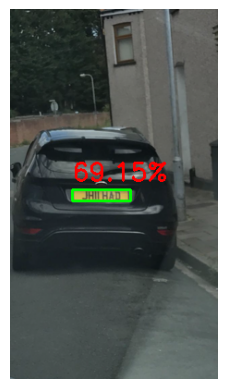


______________________________________________________________________________________________________________

Number on License Plate: | JHTHAD |



In [214]:
detect(image_path='/kaggle/working/datasets/cars_license_plate_new/test/images/Cars181.png',
      model=model)